In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import tqdm

import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import pearsonr

import oddt
from oddt.scoring.functions.PLECscore import PLECscore
from oddt.scoring.functions import RFScore
from oddt.scoring.functions import NNScore

In [10]:
df = pd.read_csv('./41586_2019_917_MOESM4_ESM.csv').iloc[:-4]
inhibition = df['Inhibition (%) at 10uM'].astype(float).values
smiles = df['SMILES']
zincnames = df['ZINC ID']


In [35]:
pearsonr(df['Energy'].astype('float'), df['Inhibition (%) at 10uM'].astype('float'))

(-0.39914816633737876, 2.0612964797273621e-22)

In [11]:
mols = []
with Chem.SDMolSupplier('docked.sdf') as sup:
    for m in sup:
        if m is not None:
            mols.append(m)
            
print(len(mols)//3)

653


RDKit ERROR: [15:24:36] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted
[15:24:36] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted
[15:24:42] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:24:42] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:24:42] ERROR: Could not sanitize molecule ending on line 71504
RDKit ERROR: [15:24:42] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:24:42] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:24:42] ERROR: Could not sanitize molecule ending on line 71567
RDKit ERROR: [15:24:42] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:24:42] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:24:42] ERROR: Could not sanitize molecule ending on line 71630
[15:24:42] ERROR: Could not sanitize molecule ending on line 71504
[

# Testing Re-scoring algorithms from ODDT on the D4 docking results



In [12]:
# First define a function that takes a scoring method, re-scores the compounds,
# and returns a dataframe of the results:

In [22]:
def re_score(method, mols):
    """
    Method is one of: 
    - PLEClinear_p5_l1_s65536
    - rfscore_v1
    - nnscore
    """
    rescorers = {'PLEClinear_p5_l1_s65536':PLECscore('rf'),
                'rfscore_v1':RFScore.rfscore(),
                'nnscore':NNScore.nnscore()}
    
    pickles = {'PLEClinear_p5_l1_s65536':'./PLEClinear_p5_l1_pdbbind2016_s65536.pickle',
               'rfscore_v1':'./RFScore_v1_pdbbind2016.pickle',
               'nnscore':'./NNScore_pdbbind2016.pickle'}

    names = []
    re_scores = []


    scorer = rescorers[method]
    #scorer.train()
    scorer = scorer.load(pickles[method])
    
    oddt_prot = next(oddt.toolkit.readfile('pdb', './protein_5WIU.pdbqt'))
    oddt_prot.protein=True 
    scorer.set_protein(oddt_prot)


    for m in tqdm.tqdm_notebook(mols, total=len(mols)):
        names.append(m.GetProp('_Name'))
        Chem.MolToMolFile(m, 'temp.sdf')
        oddt_lig = next(oddt.toolkit.readfile('sdf', 'temp.sdf'))
        scored_mol = scorer.predict_ligand(oddt_lig)
        re_scores.append(float(scored_mol.data[method]))
        
    re_scored_df = pd.DataFrame({'names':names, 're_scores':re_scores, 'method':method})
    re_scored_df = re_scored_df.sort_values('re_scores', ascending=False).drop_duplicates('names')
    return re_scored_df

In [23]:
rfscore = re_score('rfscore_v1',mols)

/var/folders/jh/02165y2n7kq2y5ychxtzcjm40000gn/T/ipykernel_68500/909897982.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(mols, total=len(mols)):


  0%|          | 0/1959 [00:00<?, ?it/s]

In [24]:

plecscore = re_score('PLEClinear_p5_l1_s65536',mols)

/var/folders/jh/02165y2n7kq2y5ychxtzcjm40000gn/T/ipykernel_68500/909897982.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(mols, total=len(mols)):


  0%|          | 0/1959 [00:00<?, ?it/s]

In [25]:
nnscore = re_score('nnscore', mols)

/var/folders/jh/02165y2n7kq2y5ychxtzcjm40000gn/T/ipykernel_68500/909897982.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(mols, total=len(mols)):


  0%|          | 0/1959 [00:00<?, ?it/s]

# Plot

In [26]:
small_df = pd.DataFrame({'names':zincnames, 'inhib':inhibition})

Text(0, 0.5, 'Ihibition %')

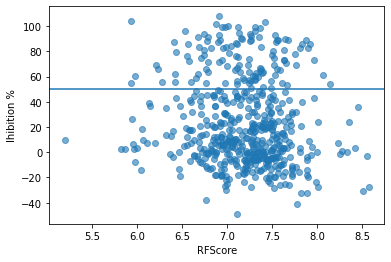

In [27]:
##rf score:
merged = rfscore.merge(small_df)

plt.scatter(merged['re_scores'], merged['inhib'],alpha=0.6)
plt.axhline(50)
plt.xlabel('RFScore')
plt.ylabel('Ihibition %')

Text(0, 0.5, 'Ihibition %')

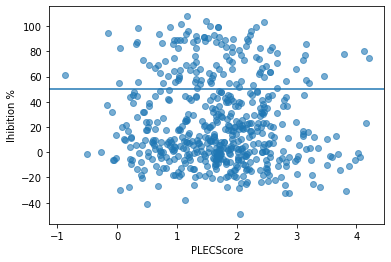

In [28]:
##PLEC score:
merged = plecscore.merge(small_df)

plt.scatter(merged['re_scores'], merged['inhib'],alpha=0.6)
plt.axhline(50)
plt.xlabel('PLECScore')
plt.ylabel('Ihibition %')

Text(0, 0.5, 'Ihibition %')

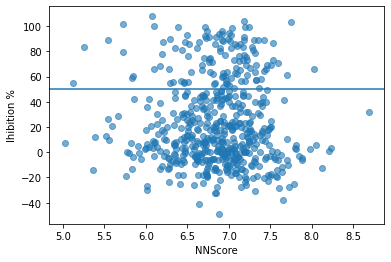

In [29]:
##NNscore (BINANA):
merged = nnscore.merge(small_df)

plt.scatter(merged['re_scores'], merged['inhib'],alpha=0.6)
plt.axhline(50)
plt.xlabel('NNScore')
plt.ylabel('Ihibition %')

In [42]:
pearsonr(merged['re_scores'], merged['inhib'])

(-0.025623590851618402, 0.5490996138006271)

In [43]:
from scipy.stats import spearmanr
spearmanr(merged['re_scores'], merged['inhib'])

SpearmanrResult(correlation=-0.021058788260573117, pvalue=0.6224697154034581)

In [39]:
scores = [float(m.GetProp('minimizedAffinity')) for m in mols]
names = [m.GetProp('_Name') for m in mols]

In [41]:
d = pd.DataFrame({'scores':scores, 'names':names})

In [46]:
srtd = d.sort_values('scores').drop_duplicates('names')

In [47]:
srtd.merge
merged = srtd.merge(small_df)


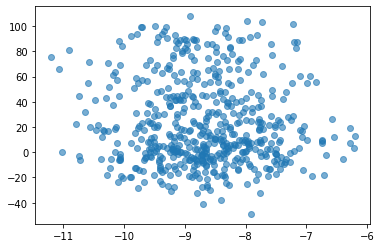

In [49]:
plt.scatter(merged['scores'], merged['inhib'],alpha=0.6)